In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import helperFunctions as hf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import datetime
import os
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

Generatiing Data

In [19]:
hf.generateTestData(root_folder=r"C:\Users\GIFT OF GOD\Desktop\self_driving_car\data", nimages_per_class=500)

Test data saved successfully to C:\Users\GIFT OF GOD\Desktop\self_driving_car\data\testData.csv


In [20]:
hf.generateTrainData(root_folder="data", validation_split=0.15, test_data=r"data\\testData.csv")

('data\\trainingData.csv', 'data\\validationData.csv')

### Gettign data for speed

In [21]:
train_ds = hf.getTfDataset(angle=False, speed=True, img_height=240, img_width= 240)

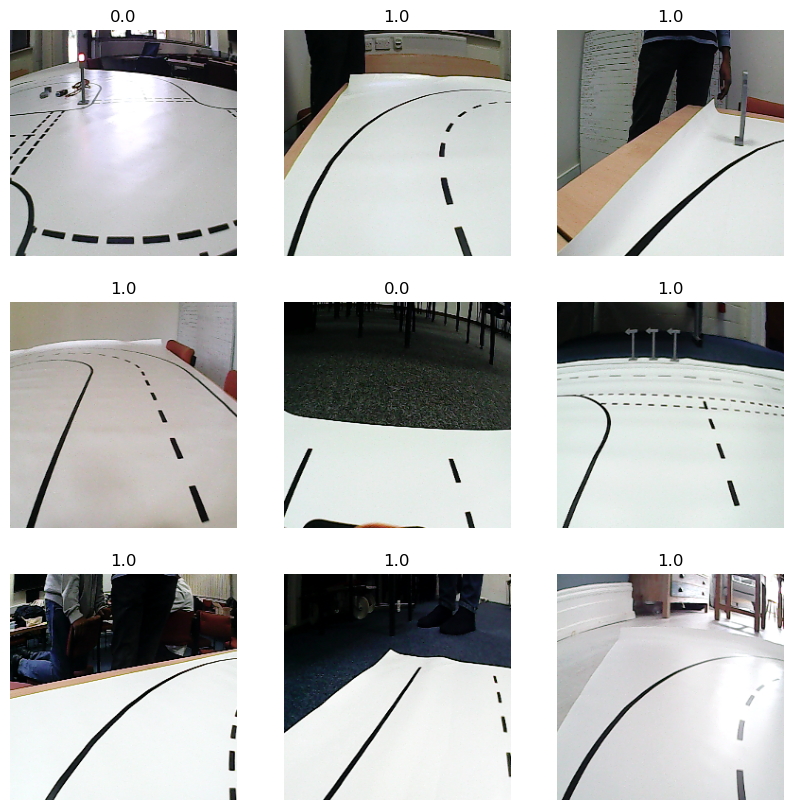

In [22]:
### Some images
image_batch, speed_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = f"{speed_batch[i]}"
  plt.title(label)
  plt.axis("off")

In [23]:
### get the validation data

valid_ds = hf.getTfDataset( path='data\\validationData.csv', angle=False, speed=True, img_height=240, img_width= 240)

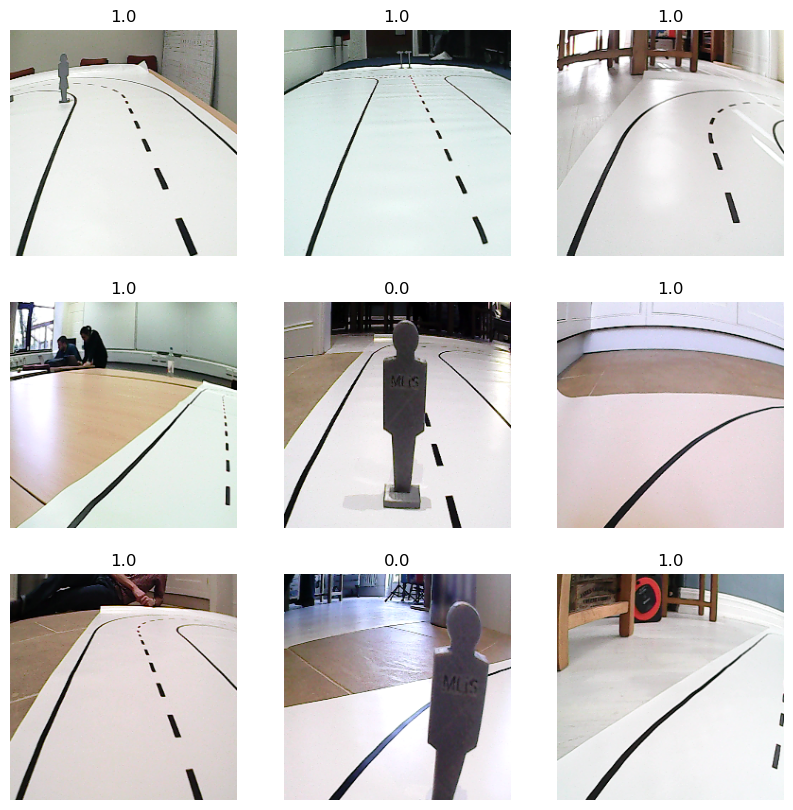

In [24]:
### Some images
val_image_batch, val_speed_batch = next(iter(valid_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(val_image_batch[i].numpy().astype("uint8"))
  label = f"{val_speed_batch[i]}"
  plt.title(label)
  plt.axis("off")

## Model

### Speed Model

In [31]:
inputs = tf.keras.layers.Input(shape=(240, 240, 3), name="input_layer")

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, 
                                                  input_tensor=inputs)


x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model.layers[-1].output)

x = tf.keras.layers.Dense(256, activation="relu")(x)

x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(1, name="speed_tl_outputs")(x)

model_speed_tl = tf.keras.models.Model(inputs, outputs)

base_model.trainable = False
# 9. Compile the model
model_speed_tl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

# summary of the model

model_speed_tl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 240, 240, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 normalization_2 (Normalization  (None, 240, 240, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 120, 120, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 120, 120, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 120, 120, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 60, 60, 144)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 60, 60, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 60, 60, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 60, 60, 144)  0          ['block2c_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 30, 30, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_s

 block4a_activation (Activation  (None, 15, 15, 288)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_expand (Conv2D)     (None, 1, 1, 528)    12144       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 15, 15, 528)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 15, 15, 88)   46464       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 15, 15, 88)  352         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_d

 block5a_project_conv (Conv2D)  (None, 15, 15, 120)  63360       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 15, 15, 120)  480        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 15, 15, 720)  86400       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 15, 15, 720)  2880       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_e

 block5d_expand_conv (Conv2D)   (None, 15, 15, 720)  86400       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 15, 15, 720)  2880       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 15, 15, 720)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 15, 15, 720)  18000      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 8, 8, 1248)  31200       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 8, 8, 1248)  4992        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1248)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_s

 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 8, 8, 1248)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1248)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_s

 block7a_se_squeeze (GlobalAver  (None, 1248)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1248)   66144       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1248)   0           ['block7a_activation[0][0]',     
          

In [32]:
base_model.trainable = False
# Check layers in our base model
for layer_number, layer in enumerate(model_speed_tl.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_

In [20]:
def unfreeze_model(model,n_layers):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[n_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model_speed_tl,1)

In [27]:
# Check layers in our base model
for layer_number, layer in enumerate(model_speed_tl.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_

In [33]:
## Early stopping callback
estop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, 
                                                  mode="min",restore_best_weights=True)

In [34]:
## Model checkpoint saving callback
# Include the epoch in the file name (uses `str.format`)
time = datetime.now().strftime("%Y_%m_%d_%I_%m")
checkpoint_path = f"model_outputs\\EfficientNetB2-v1tov4\\model_checkpoints\\training_speed_{time}"+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5*len(train_ds))


In [35]:
%%time
# 10. Fit the model  ,cp_callback
history_speed_tl = model_speed_tl.fit(train_ds,validation_data=valid_ds, batch_size=32, 
                    epochs=35,verbose=1, callbacks=[estop_callback,cp_callback])

Epoch 1/35
610/610 [==============================] - 908s 1s/step - loss: 1.1074 - accuracy: 0.8470 - val_loss: 0.4022 - val_accuracy: 0.9437
Epoch 2/35
610/610 [==============================] - 900s 1s/step - loss: 0.6232 - accuracy: 0.9122 - val_loss: 0.2927 - val_accuracy: 0.9530
Epoch 3/35
610/610 [==============================] - 937s 2s/step - loss: 0.5361 - accuracy: 0.9313 - val_loss: 0.2982 - val_accuracy: 0.9550
Epoch 4/35
610/610 [==============================] - 973s 2s/step - loss: 0.4472 - accuracy: 0.9411 - val_loss: 0.2968 - val_accuracy: 0.9588
Epoch 5/35
610/610 [==============================] - 1029s 2s/step - loss: 0.3888 - accuracy: 0.9483 - val_loss: 0.2637 - val_accuracy: 0.9678
Epoch 6/35
610/610 [==============================] - 930s 2s/step - loss: 0.3288 - accuracy: 0.9528 - val_loss: 0.2630 - val_accuracy: 0.9684
Epoch 7/35
610/610 [==============================] - 999s 2s/step - loss: 0.3182 - accuracy: 0.9564 - val_loss: 0.2525 - val_accuracy: 0.969

In [36]:
## Savign the model
model_speed_tl.save(r'model_outputs\\EfficientNetB2-v1tov4\\saved_model\\speed_model')

INFO:tensorflow:Assets written to: model_outputs\\EfficientNetB2-v1tov4\\saved_model\\speed_model\assets


INFO:tensorflow:Assets written to: model_outputs\\EfficientNetB2-v1tov4\\saved_model\\speed_model\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [195]:
##Plottign training data

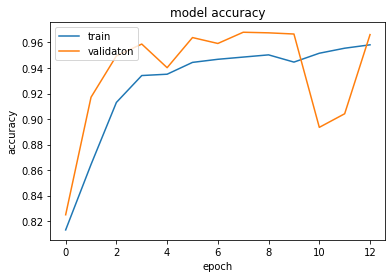

In [196]:
# summarize history for accuracy
plt.plot(history_speed.history['accuracy'])
plt.plot(history_speed.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')


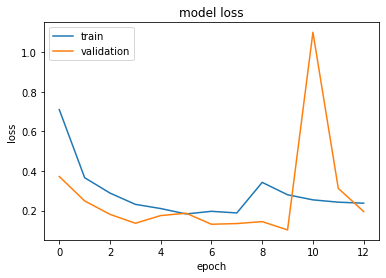

In [197]:
# summarize history for loss
plt.plot(history_speed.history['loss'])
plt.plot(history_speed.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
valid_ds_for_preds = hf.getTfDataset(r"data\validationData.csv",shuffle=False, 
                                     img_height=224, img_width=224)
validaton_df = pd.read_csv(r"data\validationData.csv")
#predictions = model_speed.predict(valid_ds_for_preds)

In [199]:
predictions = np.where(predictions>0.5,1,0)
validaton_df = pd.read_csv(r"data\validationData.csv")
validaton_df["predicted_speed"] = predictions
validaton_df.head()

image_id   angle  speed                       image_path  predicted_speed
0      4928  0.5625    1.0   data\v0\training_data\4928.png                1
1     13488  0.6250    1.0  data\v0\training_data\13488.png                1
2      9357  0.4375    1.0   data\v0\training_data\9357.png                1
3      9455  0.3750    1.0   data\v0\training_data\9455.png                1
4      5205  0.5625    1.0   data\v0\training_data\5205.png                1

In [200]:
accuracy_score(validaton_df["speed"],predictions)

0.9666512274201019

In [201]:
confusion_matrix(validaton_df["speed"],predictions)

array([[ 325,   53],
       [  19, 1762]], dtype=int64)

In [142]:
validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==1)].head(3)

image_id  angle  speed                       image_path  predicted_speed
27      10583  0.625    0.0  data\v0\training_data\10583.png                1
36      10429  0.250    0.0  data\v0\training_data\10429.png                1
122      9054  0.250    0.0   data\v0\training_data\9054.png                1

#### Images correctly classified as stop

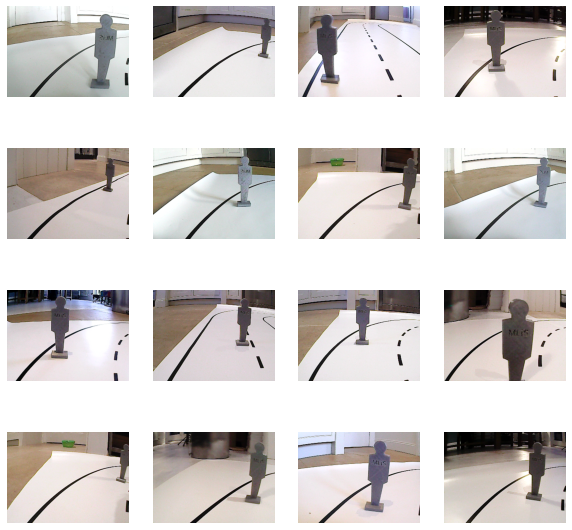

In [147]:
### Some images
images = validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==0)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

#### Images actual stop , predicted go

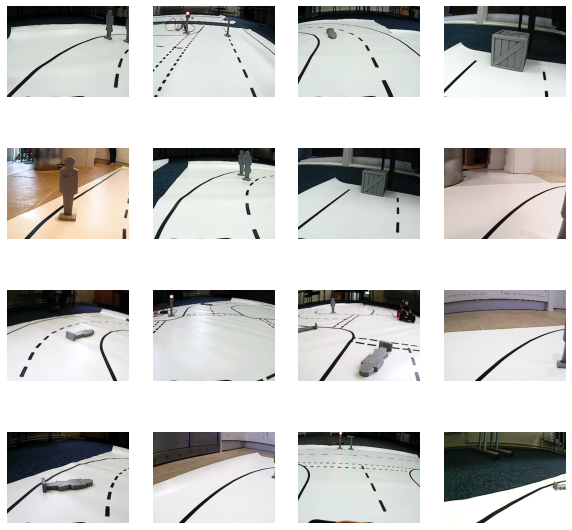

In [148]:
### Some images
images = validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==1)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

#### Images actual go , predicted stop

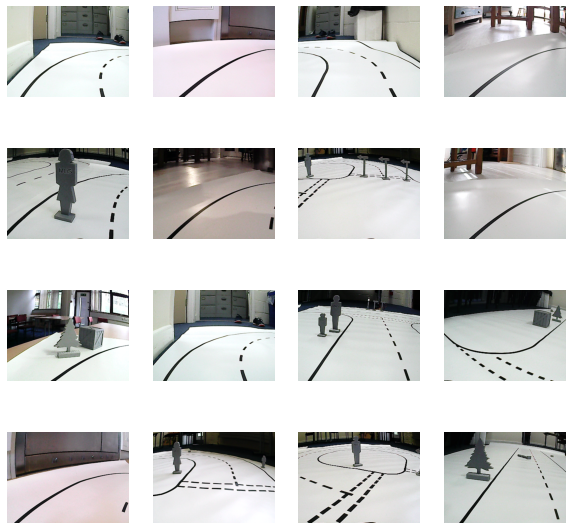

In [152]:
### Some images
images = validaton_df[(validaton_df["speed"]==1)&(validaton_df["predicted_speed"]==0)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

### Gettign data for Angle

In [5]:
train_ds = hf.getTfDataset(angle=True, speed=False, img_height=224, img_width=224)

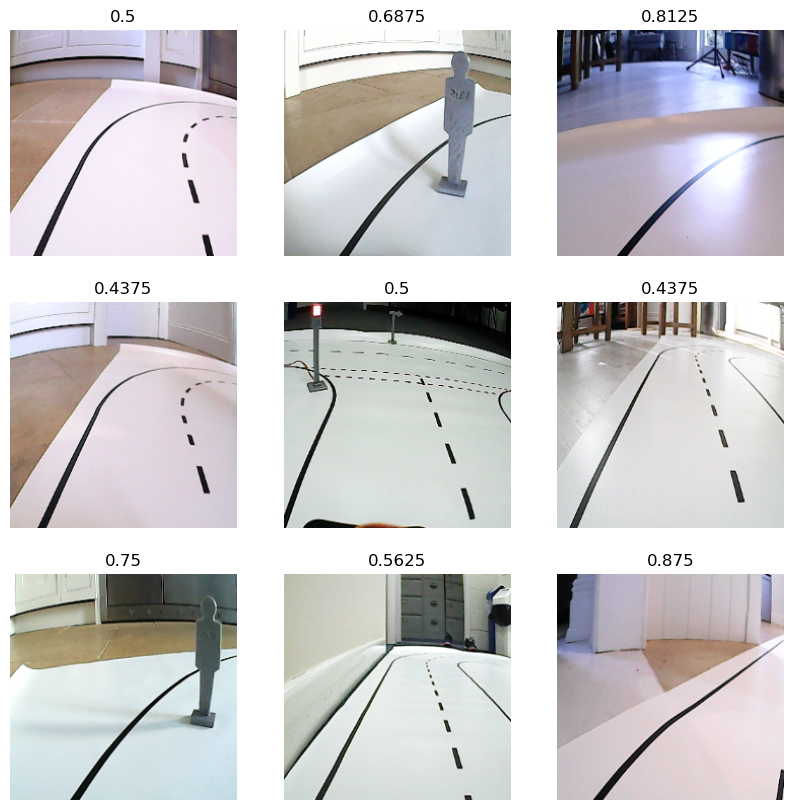

In [6]:
### Some images
image_batch, angle_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = f"{angle_batch[i]}"
  plt.title(label)
  plt.axis("off")

In [7]:
### get the validation data

valid_ds = hf.getTfDataset( path='data\\validationData.csv', angle=True, speed=False, img_height=224, img_width=224)

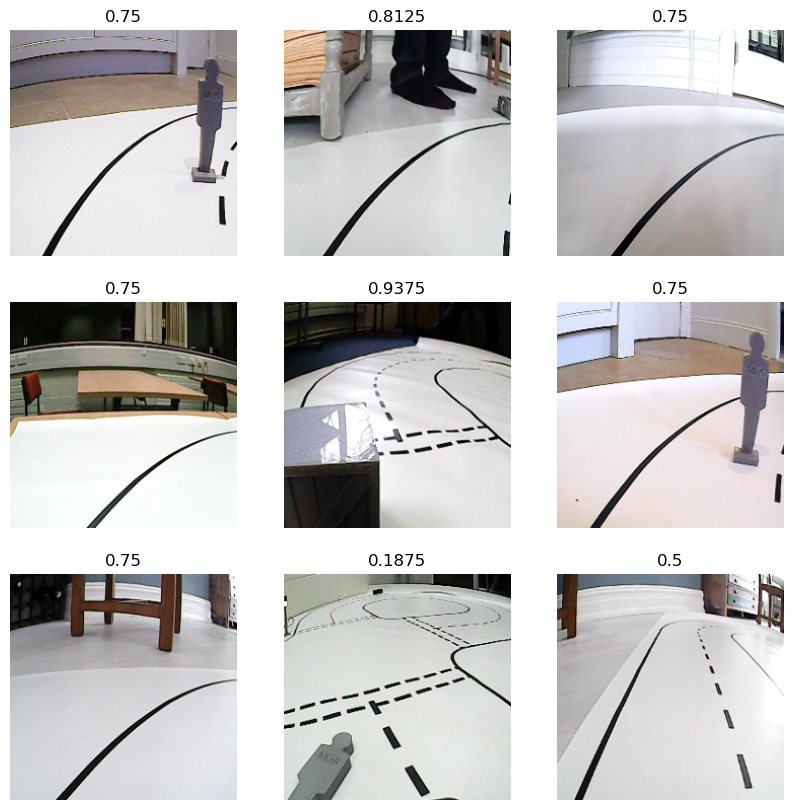

In [8]:
### Some images
val_image_batch, val_angle_batch = next(iter(valid_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(val_image_batch[i].numpy().astype("uint8"))
  label = f"{val_angle_batch[i]}"
  plt.title(label)
  plt.axis("off")

### Angle Model

In [9]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB2(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

inputs_ = tf.keras.layers.Cropping2D(cropping=((150, 0), (0, 0)), data_format=None)(inputs)

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs_)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Addign additional dense layer and dropout layer
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# 8. Create the output activation layer
outputs = tf.keras.layers.Dense(1, name="angle_tl_outputs")(x)

# 9. Combine the inputs with the outputs into a model
model_angle_tl = tf.keras.Model(inputs, outputs)

model_angle_tl.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 74, 224, 3)        0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_max_pooling_layer (G  (None, 1408)             0         
 lobalMaxPooling2D)                                              
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [10]:
# 9. Compile the model
model_angle_tl.compile(
    optimizer=keras.optimizers.Adam(1e-7),
    loss=keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [11]:
## Early stopping callback
estop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                                  mode="min",restore_best_weights=True)

In [12]:
## Model checkpoint saving callback
# Include the epoch in the file name (uses `str.format`)
time = datetime.now().strftime("%Y_%m_%d_%I_%m")
checkpoint_path = f"model_outputs\\EfficientNetB2-angle_cropped-adam\\model_checkpoints\\training_angle_{time}"+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5*len(train_ds))


In [138]:
# Freeze all layers except for the block 5
base_model.trainable = False
for layer in base_model.layers[64:]:
    layer.trainable = True

In [13]:

# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce F

In [30]:
os.listdir(r"model_outputs\EfficientNetB2-angle_cropped\model_checkpoints\training_angle_2023_03_21_08_03")

['checkpoint',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index']

In [16]:
model_angle_tl.load_weights(r"model_outputs\\EfficientNetB2-angle_cropped\\model_checkpoints\\training_angle_2023_03_21_08_03\\cp-0015.ckpt")

In [ ]:
%%time
##Train the model
history_angle = model_angle_tl.fit(train_ds,validation_data=valid_ds, batch_size=32,
                    epochs=50,verbose=1, callbacks=[estop_callback,cp_callback])

Epoch 1/50
 91/380 [======>.......................] - ETA: 4:13 - loss: 17.9906 - mean_squared_error: 17.9906

In [ ]:
## Savign the model
model_angle_tl.save(r'model_outputs\EfficientNetB2-angle_cropped-adam\saved_model\angle_model')

In [56]:
##Plottign training data

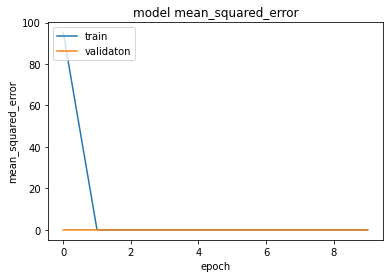

In [212]:
# summarize history for accuracy
plt.plot(history_angle.history['mean_squared_error'])
plt.plot(history_angle.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')
plt.show()

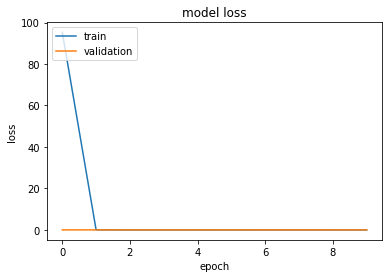

In [213]:
# summarize history for loss
plt.plot(history_angle.history['loss'])
plt.plot(history_angle.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [214]:
angle_preds = model_angle.predict(valid_ds_for_preds)

68/68 [==============================] - 5s 71ms/step


In [215]:
validaton_df = pd.read_csv(r"data\validationData.csv")
validaton_df["predicted_angle"] = angle_preds
validaton_df["diff%"] = abs(validaton_df["angle"] - validaton_df["predicted_angle"])/(validaton_df["angle"]+10**-8) * 100
validaton_df.head()


image_id   angle  speed                       image_path  predicted_angle  \
0      4928  0.5625    1.0   data\v0\training_data\4928.png         0.487325   
1     13488  0.6250    1.0  data\v0\training_data\13488.png         0.562795   
2      9357  0.4375    1.0   data\v0\training_data\9357.png         0.520378   
3      9455  0.3750    1.0   data\v0\training_data\9455.png         0.262067   
4      5205  0.5625    1.0   data\v0\training_data\5205.png         0.626491   

       diff%  
0  13.364378  
1   9.952764  
2  18.943650  
3  30.115524  
4  11.376190

In [216]:
validaton_df["diff%"].describe()

count    2.159000e+03
mean     7.781003e+06
std      1.284424e+08
min      5.693436e-03
25%      3.804376e+00
50%      7.851372e+00
75%      1.378923e+01
max      3.108009e+09
Name: diff%, dtype: float64

In [165]:
validaton_df[validaton_df["diff%"]==float("inf")]

image_id  angle  speed                       image_path  \
214      11731    0.0    1.0  data\v0\training_data\11731.png   
260       3794    0.0    1.0   data\v0\training_data\3794.png   
495        780    0.0    1.0    data\v0\training_data\780.png   
629      12049    0.0    1.0  data\v0\training_data\12049.png   
886       2926    0.0    1.0   data\v0\training_data\2926.png   
1125      7231    0.0    1.0   data\v0\training_data\7231.png   
1169      5403    0.0    1.0   data\v0\training_data\5403.png   
1517     13200    0.0    1.0  data\v0\training_data\13200.png   
2109      2557    0.0    1.0   data\v0\training_data\2557.png   

      predicted_angle  diff%  
214          0.349339    inf  
260          0.283205    inf  
495          0.172477    inf  
629          0.207177    inf  
886          0.239627    inf  
1125         0.152244    inf  
1169         0.157546    inf  
1517         0.167148    inf  
2109         0.203121    inf

## Steering angle error > 75%

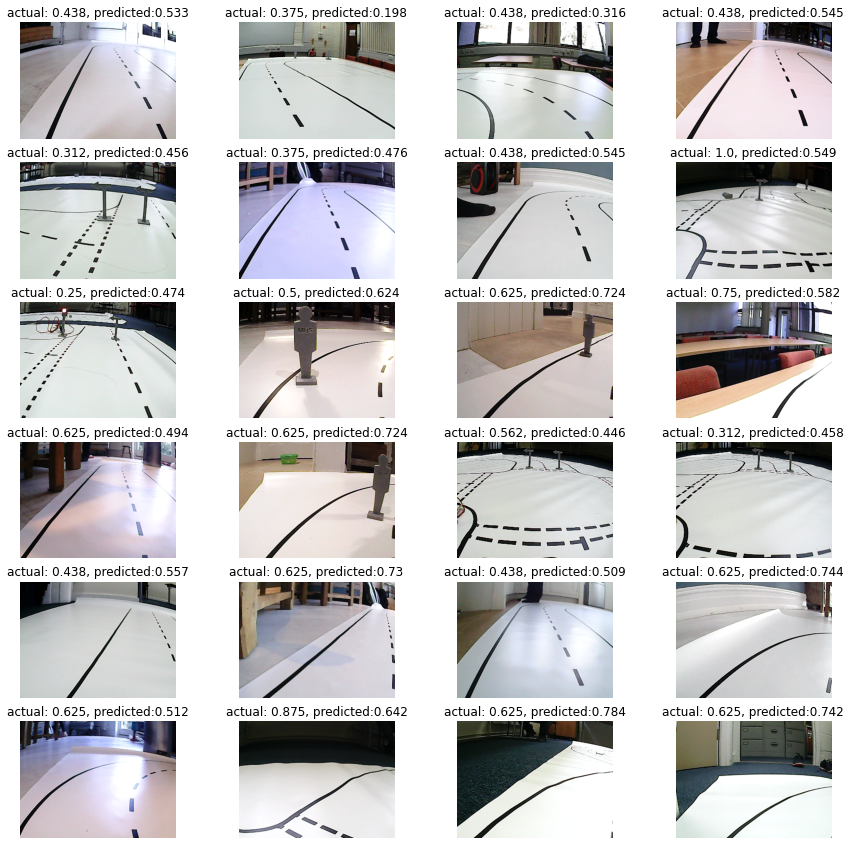

In [184]:
images = validaton_df[validaton_df["diff%"]>15]["image_path"].to_list()
actual = validaton_df[validaton_df["diff%"]>15]["angle"].to_list()
predicted = validaton_df[validaton_df["diff%"]>15]["predicted_angle"].to_list()

plt.figure(figsize=(15, 15))
for i in range(24):
  ax = plt.subplot(6, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  label = f"actual: {round(actual[i],3)}, predicted:{round(predicted[i],3)}"
  plt.title(label)
  plt.axis("off")

## Steering angle error < 25%

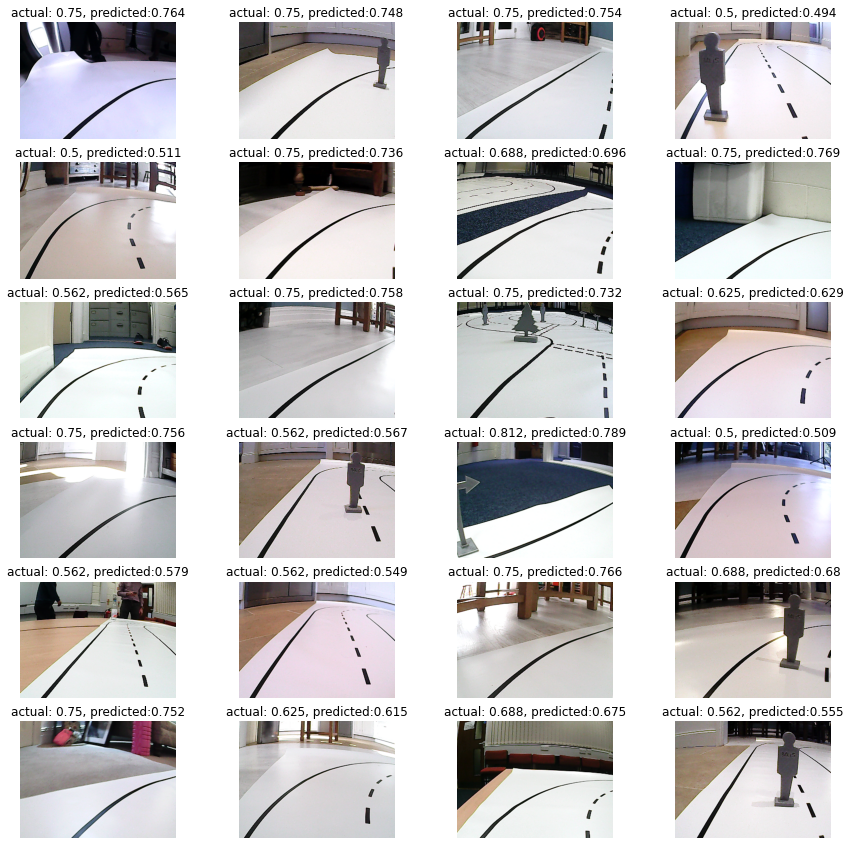

In [186]:
images = validaton_df[validaton_df["diff%"]<3]["image_path"].to_list()
actual = validaton_df[validaton_df["diff%"]<3]["angle"].to_list()
predicted = validaton_df[validaton_df["diff%"]<3]["predicted_angle"].to_list()

plt.figure(figsize=(15, 15))
for i in range(24):
  ax = plt.subplot(6, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  label = f"actual: {round(actual[i],3)}, predicted:{round(predicted[i],3)}"
  plt.title(label)
  plt.axis("off")

## merging the models

In [131]:
inputs = keras.Input(shape=(224 , 224, 3), name="img")
angle_output = model_angle_tl(inputs)
speed_output = model_speed_tl(inputs)
model = keras.Model(inputs,outputs=[angle_output,speed_output])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_13 (Functional)          (None, 1)            34262049    ['img[0][0]']                    
                                                                                                  
 model_2 (Functional)           (None, 1)            33698337    ['img[0][0]']                    
                                                                                                  
Total params: 67,960,386
Trainable params: 567,810
Non-trainable params: 67,392,576
_______

In [228]:
### savign the model
model.save(r'model_outputs\ResnetRS50\saved_model\combinedModel')

INFO:tensorflow:Assets written to: model_outputs\toy_resnet\saved_model\combinedModel\assets


INFO:tensorflow:Assets written to: model_outputs\toy_resnet\saved_model\combinedModel\assets


In [132]:
preds_combine = model.predict(valid_ds_for_preds)

68/68 [==============================] - 18s 219ms/step


In [224]:
##Old One
speed_preds = np.where(preds_combine[1]>0.5,1,0)
accuracy_score(validaton_df["speed"],speed_preds)

0.9666512274201019

In [108]:
speed_preds = np.where(preds_combine[1]>0.5,1,0)
accuracy_score(validaton_df["speed"],speed_preds)

0.9652616952292729

In [223]:
preds_combine[1]

array([[1.        ],
       [1.        ],
       [0.999742  ],
       ...,
       [0.9990707 ],
       [0.9198503 ],
       [0.97436935]], dtype=float32)

In [226]:
##Old one
angle_preds = preds_combine[0]
mean_squared_error(validaton_df["angle"],angle_preds)

0.006352738617420139

In [133]:
angle_preds = preds_combine[0]
mean_squared_error(validaton_df["angle"],angle_preds)

0.04450663943905416